In [ ]:
# default_exp engine.noise

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Noise model

> Definition of the classes used to model the camera noise

In [ ]:
#export
from decode_fish.imports import *
from torch import nn
from torch import distributions as D
from decode_fish.funcs.utils import *
import scipy.stats as stats  

In [ ]:
#export
class sCMOS(nn.Module):
    """
    Generates sCMOS noise distribution which can be used for sampling and
    calculating log probabilites.

    Theta can be learned (but no the baseline)

    Args:
        theta (float): 1/theta gives the rate for torch.distributions.gamma
        baseline (float): baseline

    """
    def __init__(self, theta = 3., baseline = 0., channels = 0, sim_scale = 1.):

        super().__init__()

        if channels:
            self.theta_scale = torch.tensor(theta)
            self.theta_par = torch.nn.Parameter(torch.ones(channels))
        else:
            self.theta_scale = theta
            self.theta_par = torch.nn.Parameter(torch.tensor(1.))

        self.theta_const = (self.theta_scale.to(self.theta_par.device) * self.theta_par).detach().cuda()

        self.register_buffer('baseline', torch.tensor(baseline))
        self.channels = channels
        self.sim_scale = sim_scale

    def forward(self, x_sim, background, const_theta_sim=False, ch_inds=None):
        """ Calculates the concentration (mean / theta) of a Gamma distribution given
        the signal x_sim and background tensors.
        Also applies a shift and returns resulting the Gamma distribution
        """

        theta = (self.theta_scale.to(self.theta_par.device) * self.theta_par)
        if const_theta_sim:
            theta = self.theta_const * self.sim_scale
            theta = theta * torch.zeros_like(theta).uniform_(0.3,3)
        else:
            theta = theta * self.sim_scale
        if ch_inds is None:  
            theta = theta[None,:,None,None,None]
        else:
            theta = theta[ch_inds]
            theta = theta[:,None,None,None,None]

        x_sim_background = x_sim + background
        x_sim_background.clamp_(1.0 + self.baseline)

        conc = (x_sim_background - self.baseline) / theta
        xsim_dist = D.Gamma(concentration=conc, rate=1 / theta)

        loc_trafo = [D.AffineTransform(loc=self.baseline, scale=1)]
        xsim_dist = D.TransformedDistribution(xsim_dist, loc_trafo)
        return xsim_dist


In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.microscope import Microscope
from decode_fish.funcs.plotting import plot_3d_projections
from decode_fish.funcs.file_io import get_gaussian_psf

psf = get_gaussian_psf([1,21,21],[1.,1.,1.], pred_z=True)
noise = sCMOS(theta=15., baseline=0, channels=12)
psf.psf_fac = 1
micro = Microscope(psf=psf, noise=noise, scale=1000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,16,48,48]).cuda()*.01, int_conc=1., channels=12)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample()
ch_inps = micro.get_single_ch_inputs(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

xsim = micro(*ch_inps)

background = torch.ones_like(xsim) * 500
xsim_noise = micro.noise(xsim, background).sample()

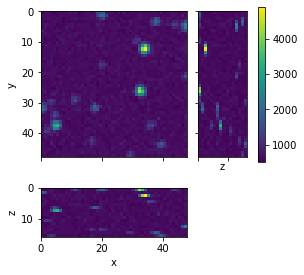

In [ ]:
from decode_fish.funcs.plotting import plot_3d_projections
_ = plot_3d_projections(xsim_noise[0,2], size=3)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
